# Datathon Alicorp 2023
- Team name: Las capibaras
- Team members: Santiago Arámbulo y Valerie Dube

## Context
Alicorp is a Peruvian company with operations in Latin America that manufactures, distributes and sells consumer staples goods. It has three main B2B2C clients: "bodegas", restaurants, and bakerys. These customers may buy products using digital or traditional channels. Alicorp's digital channels include the apps Diadía for "bodegas" and INSUMA for restaurants and bakerys.

## Goal
Develope a model that recommends the top 30 products the client is more likely to purchase in the next week.

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from surprise import Dataset, Reader, SVD
from scipy.stats import poisson

## 1. Preprocessing

In [2]:
# Sales data
df_ventas = pd.read_csv('train.csv', sep='|')

# Products data
df_productos = pd.read_csv('RentabilidadProduct.csv', sep='|')

In [3]:
df_ventas.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,0.005211
1,2022-01-31,7157,512,BO,21,V,1.0,0.153431,0.005211
2,2022-01-31,9382,510,BO,21,V,1.0,0.153431,0.005211
3,2022-01-31,9382,512,BO,21,V,1.0,0.153431,0.005211
4,2022-01-31,9382,525,BO,21,V,1.0,0.153431,0.005790


In [4]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167848 entries, 0 to 2167847
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   fecha_compra        object 
 1   customer_id         int64  
 2   product_id          int64  
 3   type_id             object 
 4   business_id         int64  
 5   channel_id          object 
 6   cantidad_venta      float64
 7   monto_venta_transf  float64
 8   peso_venta_transf   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 148.9+ MB


In [5]:
df_ventas.describe()

,customer_id,product_id,business_id,cantidad_venta,monto_venta_transf,peso_venta_transf
count,2.167848e+06,2.167848e+06,2.167848e+06,2.167848e+06,2.167848e+06,2.167848e+06
mean,6.495294e+03,4.327939e+02,3.079470e+01,4.033649e+00,2.678429e+01,4.801825e+00
std,4.130133e+03,3.021948e+02,1.384631e+01,6.993144e+00,1.255970e+02,3.601104e+01
min,1.000000e+00,1.000000e+00,2.100000e+01,1.000000e+00,2.315932e-02,2.315932e-03
25%,2.687000e+03,1.720000e+02,2.100000e+01,1.000000e+00,2.055390e+00,1.748529e-01
50%,6.459000e+03,4.110000e+02,2.100000e+01,2.000000e+00,5.352699e+00,6.368814e-01
75%,9.945000e+03,6.830000e+02,5.100000e+01,5.000000e+00,1.384059e+01,2.431729e+00
max,1.531200e+04,1.048000e+03,7.100000e+01,4.800000e+02,1.685446e+04,3.473899e+03


In [6]:
# Sales date range
print((df_ventas.fecha_compra.min(), df_ventas.fecha_compra.max()))

('2022-01-31', '2023-02-04')


In [7]:
df_productos.head()

,product_id,family_id,negocio_id,category_id,tier_id,utilidad_bruta_transf
0,881,1291,20,131,4,10.378017
1,805,1224,20,131,3,10.177925
2,892,1089,20,146,1,10.008243
3,841,1224,20,131,3,7.698362
4,830,1089,20,131,1,7.353678


In [8]:
df_productos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             937 non-null    int64  
 1   family_id              937 non-null    int64  
 2   negocio_id             937 non-null    int64  
 3   category_id            937 non-null    int64  
 4   tier_id                937 non-null    int64  
 5   utilidad_bruta_transf  937 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 44.1 KB


In [9]:
# Validate that 'product_id' has unique values
print(df_productos['product_id'].nunique() == df_productos.shape[0])

True


The training data will consist of the purchases made in the last year (~52 weeks). Meanwhile, the test data consists of the purchases made in the last week

In [10]:
# Transform dates (strings) to datetime type
df_ventas['fecha_compra'] = pd.to_datetime(df_ventas['fecha_compra'])
df_ventas = df_ventas.sort_values('fecha_compra', ascending = True)

# Create variable with year and week ('semana_venta') 
df_ventas['semana_venta'] = df_ventas['fecha_compra'].dt.strftime('%Y-%U')
df_ventas.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf,semana_venta
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,0.005211,2022-05
3225,2022-01-31,1265,194,BO,21,V,1.0,10.117730,0.521085,2022-05
3224,2022-01-31,1215,194,PA,21,B,1.0,10.117730,0.521085,2022-05
3223,2022-01-31,1048,194,BO,21,V,1.0,10.117730,0.521085,2022-05
3222,2022-01-31,1030,194,BO,21,V,1.0,10.117730,0.521085,2022-05


In [11]:
# Train test split
train_daily = df_ventas[df_ventas['semana_venta'] != df_ventas['semana_venta'].max()]
test_daily = df_ventas[df_ventas['semana_venta'] == df_ventas['semana_venta'].max()]
train_daily.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf,semana_venta
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,0.005211,2022-05
3225,2022-01-31,1265,194,BO,21,V,1.0,10.117730,0.521085,2022-05
3224,2022-01-31,1215,194,PA,21,B,1.0,10.117730,0.521085,2022-05
3223,2022-01-31,1048,194,BO,21,V,1.0,10.117730,0.521085,2022-05
3222,2022-01-31,1030,194,BO,21,V,1.0,10.117730,0.521085,2022-05


We calculate the number of purchases per week for each product and client. We expect this number to follow a Poission distribution.

In [12]:
# Step 1: Group by 'product_id', 'customer_id', and 'semana_venta', and calculate the number of purchases ('cantidad_venta')
train_weekly = train_daily.groupby(['customer_id', 'product_id', 'semana_venta'], as_index=False)['cantidad_venta'].size()
train_weekly.rename(columns = {'size': 'cantidad_venta'}, inplace = True)

# Step 2: Convert 'semana_venta' column to numeric values starting from 1
train_weekly['semana_venta'] = pd.factorize(train_weekly['semana_venta'])[0] + 1
train_weekly.head()

,customer_id,product_id,semana_venta,cantidad_venta
0,1,8,1,1
1,1,11,2,1
2,1,11,3,1
3,1,11,4,1
4,1,11,5,2


In [13]:
# Step 3: Count the number of weeks since each customer made its first purchase (up until the last available week in the training dataset)
last_week = train_weekly['semana_venta'].max()
train_weekly['num_semanas'] = train_weekly.groupby('customer_id')['semana_venta'].transform(lambda x: last_week - x.min() + 1)

In [14]:
# Step 4: Calculate the total number of weekly purchases
train = train_weekly.groupby(['customer_id', 'product_id']).agg({'cantidad_venta': np.sum, 'num_semanas': 'first'}).reset_index()
train.head()

,customer_id,product_id,cantidad_venta,num_semanas
0,1,8,1,52
1,1,11,5,52
2,1,21,24,52
3,1,25,3,52
4,1,27,8,52


In [15]:
# Step 5: Divide by the total number of weeks for each customer
train['cantidad_venta'] /= train['num_semanas']

In [16]:
train['prob'] = 1 - poisson.pmf(0, train['cantidad_venta'])
train.head()

,customer_id,product_id,cantidad_venta,num_semanas,prob
0,1,8,0.019231,52,0.019047
1,1,11,0.096154,52,0.091676
2,1,21,0.461538,52,0.369687
3,1,25,0.057692,52,0.056060
4,1,27,0.153846,52,0.142596


In [17]:
# Calculate the total number of purchases made of each product by each customer in the test window 
test = test_daily.groupby(['customer_id', 'product_id'])['cantidad_venta'].sum().reset_index()
test.head()

,customer_id,product_id,cantidad_venta
0,5,106,3.0
1,5,203,6.0
2,5,297,6.0
3,5,414,1.0
4,5,417,1.0


## 2. Exploratory analysis

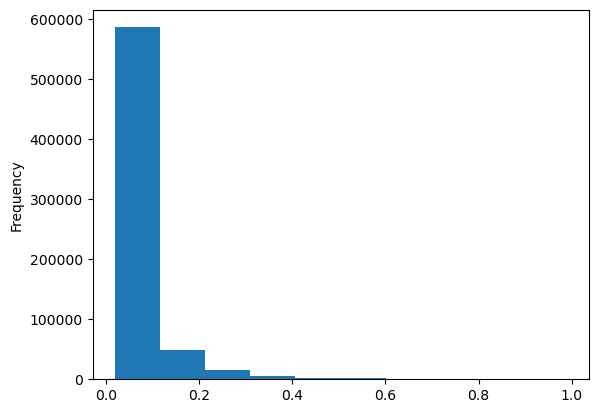

In [18]:
# Create a dictionary to store train_datasets and anti_train_datasets for each data frame
train['prob'].plot.hist()
plt.show()

Descriptive statistics

In [19]:
train['prob'].describe()

count    660830.000000
mean          0.057685
std           0.071242
min           0.019047
25%           0.019047
50%           0.037731
75%           0.059388
max           0.987770
Name: prob, dtype: float64

## 3. Modelos

### 3.1 SVD

In [20]:
# We prepare the train data
reader = Reader(rating_scale=(0, 1))
train_dataset = Dataset.load_from_df(train[['customer_id', 'product_id', 'prob']], reader).build_full_trainset()
# We create the combinations of products and customers that are missing in the training data
anti_train_dataset = train_dataset.build_anti_testset(fill=0)

# We fit the model
svd_model = SVD(n_epochs=35, reg_all = 0.01, n_factors = 80)
svd_model.fit(train_dataset) # Training the algorithm on the trainset

In [21]:
# We generate predictions for the missing combinatios of customers and products
predictions = svd_model.test(anti_train_dataset)
predictions = pd.DataFrame(
    predictions,
    columns = ["customer_id", "product_id", "global_mean", "cantidad_venta", "details"]
)
predictions = predictions[["customer_id", "product_id", "cantidad_venta"]]
predictions['flag'] = 'anti_train'

# We merge the predictions with the original data
predictions = pd.concat([train, predictions], ignore_index = True)
predictions.fillna('train', inplace = True)
predictions.head()

,customer_id,product_id,cantidad_venta,num_semanas,prob,flag
0,1,8,0.019231,52.0,0.019047,train
1,1,11,0.096154,52.0,0.091676,train
2,1,21,0.461538,52.0,0.369687,train
3,1,25,0.057692,52.0,0.05606,train
4,1,27,0.153846,52.0,0.142596,train


In [22]:
# We create a dataframe with the top 30 recommendations, giving priority to the items that have already been bought
recommendations = predictions.sort_values(
    ['customer_id', 'flag', 'prob'],
    ascending = (True, False, False)
).groupby(["customer_id"]).head(30).reset_index(drop = True).set_index('customer_id')
recommendations.head(35)

,product_id,cantidad_venta,num_semanas,prob,flag
customer_id,,,,,
1,452,0.596154,52.0,0.449073,train
1,414,0.576923,52.0,0.438376,train
1,456,0.500000,52.0,0.393469,train
1,21,0.461538,52.0,0.369687,train
1,404,0.461538,52.0,0.369687,train
1,459,0.442308,52.0,0.357448,train
1,453,0.384615,52.0,0.319288,train
1,426,0.365385,52.0,0.30607,train
1,418,0.346154,52.0,0.292596,train


The optimization metric is the recall, defined as the percentaje of recommeded products that were actually bought (hits)

In [23]:
def check_hit(purchase, recommendations):
    user_recommendations = recommendations.loc[purchase.customer_id, 'product_id']
    hit = any(purchase.product_id == user_recommendations)
    return pd.Series([purchase.customer_id, purchase.product_id, hit], index = ['customer_id', 'product_id', 'hit'])

In [24]:
recalls = test.apply(lambda x: check_hit(x, recommendations), axis = 1).groupby('customer_id')['hit'].mean()
recalls.head()

customer_id
5.0     0.307692
7.0     0.500000
8.0     0.727273
9.0     0.500000
10.0    0.666667
Name: hit, dtype: float64

In [25]:
print(f"The average recall with the first model is {recalls.mean():.1%}")

The average recall with the first model is 71.3%


### 3.2 SVD punishing old purchases

The most recent week may be more important for recommending products. For example, if a customer made a single purchase of a product 40 weeks ago, it is very unlikely that it will buy that product again next week. But if it bought a product for the first time the past week, it might buy it again next week.

In [26]:
def punish_purchases(row):
    cantidad_venta = row['cantidad_venta']
    semana_venta = row['semana_venta']

    if semana_venta <= 13:
        return 0.2 * cantidad_venta
    elif semana_venta <= 26:
        return 0.6 * cantidad_venta
    elif semana_venta <= 39:
        return 0.9 * cantidad_venta
    else:
        return cantidad_venta

train_weekly['punished_purchases'] = train_weekly.apply(punish_purchases, axis=1)

In [27]:
# Calculate the total number of weighted weekly purchases
train = train_weekly.groupby(['customer_id', 'product_id']).agg(cantidad_venta = ('punished_purchases', np.sum), num_semanas = ('num_semanas', 'first')).reset_index()
train.head()

,customer_id,product_id,cantidad_venta,num_semanas
0,1,8,0.2,52
1,1,11,1.0,52
2,1,21,10.0,52
3,1,25,1.3,52
4,1,27,5.2,52


In [28]:
# Divide by the total number of weeks for each customer
train['cantidad_venta'] /= train['num_semanas']

In [29]:
train['prob'] = 1 - poisson.pmf(0, train['cantidad_venta'])
train.head()

,customer_id,product_id,cantidad_venta,num_semanas,prob
0,1,8,0.003846,52,0.003839
1,1,11,0.019231,52,0.019047
2,1,21,0.192308,52,0.174947
3,1,25,0.025000,52,0.024690
4,1,27,0.100000,52,0.095163


In [30]:
def generate_recommendations(train):
    # We prepare the train data
    reader = Reader(rating_scale=(0, 1))
    train_dataset = Dataset.load_from_df(train[['customer_id', 'product_id', 'prob']], reader).build_full_trainset()
    
    # We create the combinations of products and customers that are missing in the training data
    anti_train_dataset = train_dataset.build_anti_testset(fill=0)

    # We fit the model
    svd_model = SVD(n_epochs=35, reg_all = 0.01, n_factors = 80)
    svd_model.fit(train_dataset) # Training the algorithm on the trainset

    # We generate predictions for the missing combinatios of customers and products
    predictions = svd_model.test(anti_train_dataset)
    predictions = pd.DataFrame(
        predictions,
        columns = ["customer_id", "product_id", "global_mean", "cantidad_venta", "details"]
    )
    predictions = predictions[["customer_id", "product_id", "cantidad_venta"]]
    predictions['flag'] = 'anti_train'

    # We merge the predictions with the original data
    predictions = pd.concat([train, predictions], ignore_index = True)
    predictions.fillna('train', inplace = True)

    # We create a dataframe with the top 30 recommendations, giving priority to the items that have already been bought
    recommendations = predictions.sort_values(
        ['customer_id', 'flag', 'prob'],
        ascending = (True, False, False)
    ).groupby(["customer_id"]).head(30).reset_index(drop = True).set_index('customer_id')

    return recommendations

In [31]:
recommendations = generate_recommendations(train)
recalls = test.apply(lambda x: check_hit(x, recommendations), axis = 1).groupby('customer_id')['hit'].mean()
print(f"The average recall with the punishing model is {recalls.mean():.1%}")

The average recall with the punishing model is 71.4%


### 3.3 SVD with seasonal consideration

The clients might purchase some products more often in the summer or winter. Therefore, the same weeks of the past year and the most recen weeks might be more useful to predict next weeks purchases.

In [32]:
def seasonal_purchases(row):
    cantidad_venta = row['cantidad_venta']
    semana_venta = row['semana_venta']

    if semana_venta <= 5:
        return 0.5 * cantidad_venta
    elif semana_venta <= 48:
        return 0.2 * cantidad_venta
    else:
        return cantidad_venta

train_weekly['seasonal_purchases'] = train_weekly.apply(seasonal_purchases, axis=1)

In [33]:
# Calculate the total number of weighted weekly purchases
train = train_weekly.groupby(['customer_id', 'product_id']).agg(cantidad_venta = ('seasonal_purchases', np.sum), num_semanas = ('num_semanas', 'first')).reset_index()
train.head()

,customer_id,product_id,cantidad_venta,num_semanas
0,1,8,0.5,52
1,1,11,2.5,52
2,1,21,5.4,52
3,1,25,0.9,52
4,1,27,1.6,52


In [34]:
# Divide by the total number of weeks for each customer
train['cantidad_venta'] /= train['num_semanas']

In [35]:
train['prob'] = 1 - poisson.pmf(0, train['cantidad_venta'])
train.head()

,customer_id,product_id,cantidad_venta,num_semanas,prob
0,1,8,0.009615,52,0.009569
1,1,11,0.048077,52,0.046940
2,1,21,0.103846,52,0.098636
3,1,25,0.017308,52,0.017159
4,1,27,0.030769,52,0.030301


In [36]:
recommendations = generate_recommendations(train)
recalls = test.apply(lambda x: check_hit(x, recommendations), axis = 1).groupby('customer_id')['hit'].mean()
print(f"The average recall with the seasonal model is {recalls.mean():.1%}")

The average recall with the seasonal model is 70.4%


### 3.4 Model with client clusters

We will group clients into clusters and train a model for each cluster. This allows us to take into consideration additional features about the clients, like (i) which channel de the use more commonly, (ii) which tier of products do they purchase more frequently, (iii) how regularly do the make orders, and (iv) what is the average size of their orders.

In [37]:
cluster_data = df_ventas.merge(df_productos, on = "product_id", how = "left").fillna(0)
# Some sales include products for which there is no information on the products table. We will assign a "family_id", "category_id" and "tier_id" of 0 to these products.

In [38]:
channels = cluster_data.pivot_table(index = "customer_id", columns = "channel_id", values = "monto_venta_transf", aggfunc= np.sum)
channels = channels.apply(lambda x: x / x.sum(), axis = 1).fillna(0)
channels.head()

channel_id,A,B,V
customer_id,,,
1,0.053550,0.0,0.946450
2,0.323485,0.0,0.676515
3,0.539578,0.0,0.460422
4,0.427342,0.0,0.572658
5,0.038467,0.0,0.961533


In [39]:
tier = cluster_data.pivot_table(index = "customer_id", columns = "tier_id", values = "monto_venta_transf", aggfunc= np.sum)
tier = tier.apply(lambda x: x / x.sum(), axis = 1).fillna(0)
tier.columns = ["sin_categoria", "premium", "mainstream", "economy", "super_economy"]
tier.head()

,sin_categoria,premium,mainstream,economy,super_economy
customer_id,,,,,
1,0.067879,0.327700,0.098601,0.242585,0.263235
2,0.009126,0.495893,0.199430,0.178595,0.116956
3,0.130580,0.414207,0.047419,0.282138,0.125656
4,0.107333,0.316058,0.125964,0.154162,0.296483
5,0.148519,0.230595,0.076560,0.302351,0.241976


In [40]:
cluster_data["fecha_compra"] = cluster_data["fecha_compra"].astype('datetime64[ns]')
cluster_data.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf,semana_venta,family_id,negocio_id,category_id,tier_id,utilidad_bruta_transf
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,0.005211,2022-05,1427.0,20.0,173.0,2.0,-0.306416
1,2022-01-31,1265,194,BO,21,V,1.0,10.117730,0.521085,2022-05,1170.0,21.0,155.0,1.0,2.657334
2,2022-01-31,1215,194,PA,21,B,1.0,10.117730,0.521085,2022-05,1170.0,21.0,155.0,1.0,2.657334
3,2022-01-31,1048,194,BO,21,V,1.0,10.117730,0.521085,2022-05,1170.0,21.0,155.0,1.0,2.657334
4,2022-01-31,1030,194,BO,21,V,1.0,10.117730,0.521085,2022-05,1170.0,21.0,155.0,1.0,2.657334


In [41]:
frequency = cluster_data.groupby("customer_id")["fecha_compra"].agg(lambda x: x.nunique() / ((x.max() - x.min()).days + 1))
frequency.name = "frequency"
frequency.head()

customer_id
1    0.356354
2    0.052778
3    0.070423
4    0.042980
5    0.233062
Name: frequency, dtype: float64

In [42]:
ticket = cluster_data.groupby(["customer_id", "fecha_compra"])["monto_venta_transf"].sum().groupby("customer_id").mean()
ticket.name = "ticket"
ticket.head()

customer_id
1    35.054061
2    26.078313
3    29.232973
4    34.535956
5    20.571236
Name: ticket, dtype: float64

In [43]:
customer_data = pd.concat([channels, tier, frequency, ticket], join = "inner", axis = 1).reset_index()
customer_data.head()

,customer_id,A,B,V,sin_categoria,premium,mainstream,economy,super_economy,frequency,ticket
0,1,0.053550,0.0,0.946450,0.067879,0.327700,0.098601,0.242585,0.263235,0.356354,35.054061
1,2,0.323485,0.0,0.676515,0.009126,0.495893,0.199430,0.178595,0.116956,0.052778,26.078313
2,3,0.539578,0.0,0.460422,0.130580,0.414207,0.047419,0.282138,0.125656,0.070423,29.232973
3,4,0.427342,0.0,0.572658,0.107333,0.316058,0.125964,0.154162,0.296483,0.042980,34.535956
4,5,0.038467,0.0,0.961533,0.148519,0.230595,0.076560,0.302351,0.241976,0.233062,20.571236


In [44]:
# Scaling the data and storing the output as a new dataframe
scaler = StandardScaler()
data_scaled = customer_data.set_index("customer_id")
data_scaled = pd.DataFrame(
    scaler.fit_transform(data_scaled),
    columns=data_scaled.columns,
    index=data_scaled.index 
)
data_scaled.head()

,A,B,V,sin_categoria,premium,mainstream,economy,super_economy,frequency,ticket
customer_id,,,,,,,,,,
1,-0.187101,-1.224059,1.556799,0.285172,0.219252,-0.445711,-0.147385,0.406639,3.271394,-0.365172
2,1.198884,-1.224059,0.766319,-0.548902,0.971161,-0.035475,-0.401943,-0.361229,-0.664923,-0.399139
3,2.308417,-1.224059,0.133508,1.175285,0.605983,-0.653953,0.009963,-0.315560,-0.436132,-0.387201
4,1.732140,-1.224059,0.462181,0.845266,0.167207,-0.334381,-0.499142,0.581171,-0.791966,-0.367133
5,-0.264542,-1.224059,1.600967,1.429950,-0.214860,-0.535388,0.090372,0.295044,1.672738,-0.419979


In [45]:
# Creating copy of the data to store labels from each algorithm
data_scaled_copy = data_scaled.copy(deep=True)

K-Means Clustering

c:\Users\asara\anaconda3\envs\RecommendationSystems\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\asara\anaconda3\envs\RecommendationSystems\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\asara\anaconda3\envs\RecommendationSystems\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\asara\anaconda3\envs\RecommendationSystems\Lib\site-packages\sklearn\cluster\_kmeans.

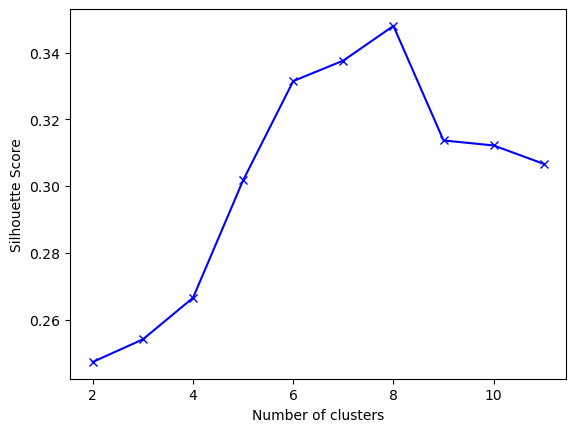

In [46]:
silhouette_scores = {} 

# iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that k 
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_scaled)
    labels = kmeans.predict(data_scaled)
    silhouette_scores[k] = silhouette_score(data_scaled, labels)

#Elbow plot
plt.figure()
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [47]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
kmeans.fit(data_scaled)

# Adding predicted labels to the original data
customer_data['cluster'] = kmeans.predict(data_scaled)
customer_data.head()

c:\Users\asara\anaconda3\envs\RecommendationSystems\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,customer_id,A,B,V,sin_categoria,premium,mainstream,economy,super_economy,frequency,ticket,cluster
0,1,0.053550,0.0,0.946450,0.067879,0.327700,0.098601,0.242585,0.263235,0.356354,35.054061,2
1,2,0.323485,0.0,0.676515,0.009126,0.495893,0.199430,0.178595,0.116956,0.052778,26.078313,2
2,3,0.539578,0.0,0.460422,0.130580,0.414207,0.047419,0.282138,0.125656,0.070423,29.232973,7
3,4,0.427342,0.0,0.572658,0.107333,0.316058,0.125964,0.154162,0.296483,0.042980,34.535956,7
4,5,0.038467,0.0,0.961533,0.148519,0.230595,0.076560,0.302351,0.241976,0.233062,20.571236,2


In [48]:
# Distribution of clients by type ("bodega", restaurant or bakery) and cluster
df_ventas[["customer_id", "type_id"]].drop_duplicates().merge(customer_data).pivot_table(index = "type_id", columns = "cluster", values = "customer_id", aggfunc=np.size)

cluster,0,1,2,3,4,5,6,7
type_id,,,,,,,,
BO,51.0,NaN,3567.0,4.0,6.0,3.0,NaN,1335.0
GA,240.0,1256.0,357.0,2210.0,1176.0,2620.0,96.0,2.0
PA,NaN,919.0,196.0,150.0,509.0,427.0,187.0,1.0


The clusters we have identify are related to the type of each business, but include additional information. For example, clusters 2 and 7 represent two distinct types of "bodegas".

In [49]:
customer_data.groupby("cluster").mean()

,customer_id,A,B,V,sin_categoria,premium,mainstream,economy,super_economy,frequency,ticket
cluster,,,,,,,,,,,
0,9379.560137,0.056043,0.499762,0.444195,0.363935,0.132170,0.247441,0.134500,0.121954,0.060353,32.125306
1,7910.017011,0.004296,0.774443,0.221261,0.016357,0.620286,0.081695,0.182711,0.098952,0.084618,144.425745
2,7402.687136,0.108560,0.026405,0.865035,0.074217,0.361776,0.117704,0.271546,0.174757,0.159998,39.079877
3,7679.528765,0.004891,0.822785,0.172325,0.020095,0.102349,0.063026,0.753830,0.060699,0.087170,167.355030
4,7829.455352,0.004622,0.744240,0.251138,0.015500,0.138912,0.104551,0.131943,0.609094,0.097996,196.252513
5,8368.699344,0.004867,0.723711,0.271422,0.030618,0.101831,0.625404,0.103112,0.139035,0.083115,104.871843
6,7556.339223,0.002906,0.819995,0.177099,0.004383,0.262404,0.366723,0.141337,0.225154,0.086003,1550.457938
7,5789.630792,0.650193,0.000445,0.349362,0.086835,0.393860,0.086316,0.274127,0.158861,0.061968,32.662563


In [57]:
# Calculate the total number of weekly purchases from scratch
train = train_weekly.groupby(['customer_id', 'product_id']).agg({'cantidad_venta': np.sum, 'num_semanas': 'first'}).reset_index()
train['cantidad_venta'] /= train['num_semanas']
train['prob'] = 1 - poisson.pmf(0, train['cantidad_venta'])

# Add the clusters
train = train.merge(customer_data[['customer_id', 'cluster']], on='customer_id', how='left')
train.tail()

,customer_id,product_id,cantidad_venta,num_semanas,prob,cluster
660825,15312,672,0.1250,16,0.117503,4
660826,15312,739,0.0625,16,0.060587,4
660827,15312,772,0.1875,16,0.170971,4
660828,15312,813,0.0625,16,0.060587,4
660829,15312,976,0.0625,16,0.060587,4


In [58]:
# Obtain unique clusters labels
clusters = train['cluster'].unique()

recommendations = pd.DataFrame()

# Generate recommendations for each cluster
for cluster in clusters:
    train_cluster = train[(train['cluster'] == cluster)]
    if not train_cluster.empty:  # Verificar si el DataFrame no está vacío
        recommendations = pd.concat([recommendations, generate_recommendations(train_cluster)])


In [59]:
recommendations.head()

,product_id,cantidad_venta,num_semanas,prob,cluster,flag
customer_id,,,,,,
1,452,0.596154,52.0,0.449073,2.0,train
1,414,0.576923,52.0,0.438376,2.0,train
1,456,0.500000,52.0,0.393469,2.0,train
1,21,0.461538,52.0,0.369687,2.0,train
1,404,0.461538,52.0,0.369687,2.0,train


In [60]:
recalls = test.apply(lambda x: check_hit(x, recommendations), axis = 1).groupby('customer_id')['hit'].mean()
print(f"The average recall with the cluster model is {recalls.mean():.1%}")

The average recall with the cluster model is 72.0%


## Output

In [61]:
# Concatenate the product_ids for each customer_id into a single row
resultados = recommendations.groupby('customer_id')['product_id'].apply(lambda x: ' '.join(map(str, x))).reset_index()

In [62]:
# Convert 'customer_id' to string and sort the DataFrame by 'customer_id'
resultados['customer_id'] = resultados['customer_id'].astype(str)
resultados = resultados.sort_values(by='customer_id')

In [64]:
resultados.to_csv('resultados.csv', index=False)
resultados.head(10)

,customer_id,product_id
0,1,452 414 456 21 404 459 453 426 418 406 417 428...
9,10,21 1028 453 610 891 120 456 459 62 230 315 452...
99,100,452 76 1035 445 561 1031 11 190 227 312 388 40...
999,1000,452 455 496 610 11 456 413 414 521 890 131 145...
9999,10000,772 66 166 773 801 812 146 328 973 177 312 88 ...
10000,10001,197 916 11 94 55 145 635 660 774 95 98 146 202...
10001,10002,203 190 120 202 199 659 610 77 88 194 839 890 ...
10002,10003,66 163 172 973 174 38 772 812 328 739 119 150 ...
10003,10004,414 426 450 441 496 428 413 461 404 451 425 45...
10004,10005,66 328 177 739 973 119 772 3 39 163 165 178 18...
